# STAT 530 Homework 4 Analysis in Python

## Instructions

Conduct the following analyses using the `golub.csv` file, available on Canvas. The data are from [https://www.openintro.org/data/index.php?data=golub](https://www.openintro.org/data/index.php?data=golub) and the website describes the rows and columns.

Please install the packages before you get started. Run:

```{bash}
conda activate stat530

mamba install umap-learn scikit-learn seaborn numpy pandas matplotlib statsmodels

```

Export your solutions to HTML and submit the HTML file on Canvas.

## Problem 1 (2 points)

Using UMAP, construct two latent numeric features using the 7,129 gene expression values for each patient, then visualize the patients using these two features (1 point), coloring each patient by cancer type (1 point). You can use the default parameters when you run the UMAP algorithm.

c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


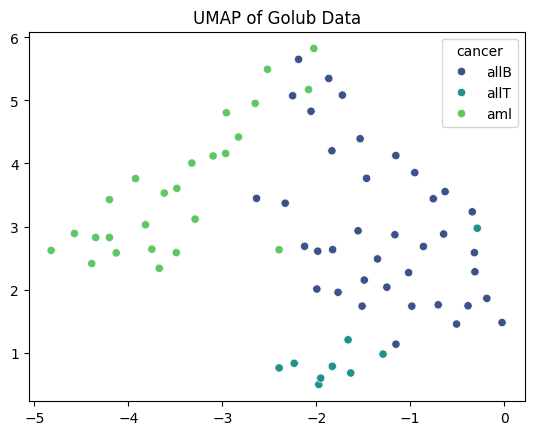

In [30]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('golub.csv')

# Extract gene expression and labels
X = df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")
labels = df.iloc[:, 5]

# UMAP
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)

# Plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=labels, palette="viridis")
plt.title("UMAP of Golub Data")
plt.show()

## Problem 2 (3 points)

Calculate the first 5 principal components of the gene expression data, after scaling the data to have mean 0 and variance 1 (1 point). Based on these principal components, use the $k$-means clustering algorithm to group the patients into three clusters (1 point). Visualize the patients using their UMAP coordinates but this time color them using the $k$-means cluster assignments (1 point).

In [31]:
# Extract numeric gene expression columns
X = df.iloc[:, 6:].apply(pd.to_numeric, errors="coerce")

# Fill any missing values
X.fillna(X.mean(), inplace=True)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for 5 components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print("Shape of first 5 principal components:", X_pca.shape)

Shape of first 5 principal components: (72, 5)


In [32]:
from sklearn.cluster import KMeans

# k-means on the PCA-reduced data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

c:\Users\viraj\anaconda3\envs\stat530\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


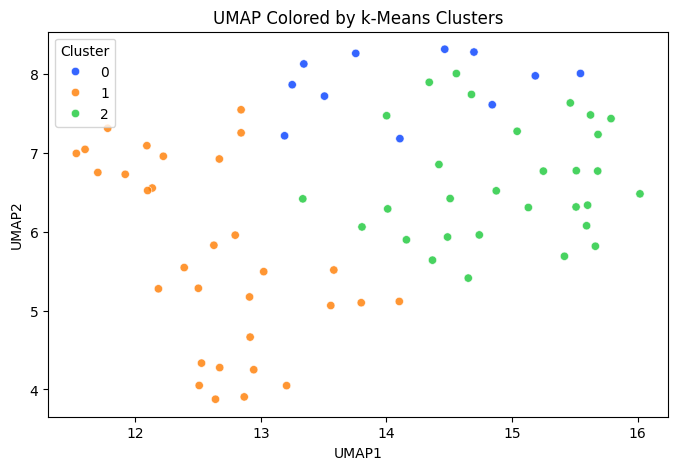

In [33]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# UMAP on the same scaled data (X_scaled)
umap_model = umap.UMAP()
X_umap = umap_model.fit_transform(X_scaled)

# Create a DataFrame for plotting
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
umap_df["Cluster"] = clusters

# Plot UMAP colored by cluster labels
plt.figure(figsize=(8, 5))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Cluster", palette="bright", alpha=0.8)
plt.title("UMAP Colored by k-Means Clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cluster")
plt.show()

## Problem 3 (4 points)

Identify genes that are differentially expressed between subjects with AML and those without, adjusting for possible confounding by whether the patient sample came from bone marrow or peripheral blood (1 point). Define a gene to be differential expressed if it has a false discovery rate of at most 0.05 (1 point). How many genes are differentially expressed (1 point)? What is the gene symbol of the most differentially expressed gene, by $p$-value (1 point)?

In [40]:
# Create binary indicators
df["aml_flag"] = (df["cancer"] == "aml").astype(int)
df["bm_flag"] = (df["BM.PB"] == "BM").astype(int)

# Design matrix for the linear model
X_data = df[["aml_flag", "bm_flag"]]
X_data = sm.add_constant(X_data)

# Loop over all gene-expression columns and store p-values for AML effect
genes = df.columns[6:]
pvals = {}
for g in genes:
    y = df[g]
    model = sm.OLS(y, X_data).fit()
    pvals[g] = model.pvalues["aml_flag"]

print("Stored p-values for AML effect in pvals.")


Stored p-values for AML effect in pvals.


In [35]:
from statsmodels.stats.multitest import multipletests

pvals_list = list(pvals.values())
genes_list = list(pvals.keys())

reject, pvals_corrected, _, _ = multipletests(pvals_list, alpha=0.05, method="fdr_bh")

results_df = pd.DataFrame({
    "Gene": genes_list,
    "Raw_pvalue": pvals_list,
    "Adj_pvalue": pvals_corrected,
    "Reject_H0": reject
})


In [38]:
num_de = results_df["Reject_H0"].sum()
print("Number of differentially expressed genes (FDR ≤ 0.05):", num_de)


Number of differentially expressed genes (FDR ≤ 0.05): 1042


In [39]:
results_sorted = results_df.sort_values("Raw_pvalue")
top_gene = results_sorted.iloc[0]["Gene"]
print("Gene with smallest p-value:", top_gene)

Gene with smallest p-value: aml_flag
